# Quantum Classifier for kaggle titanic problem

## 1. Import packages
paddle requires protobuf versions 3.1.0 through 3.20.0 so an environment variable must be set

In [1]:
import os
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'

In [24]:
import pandas as pd
import numpy as np
import paddle
import paddle_quantum
from paddle_quantum.dataset import *
from paddle_quantum.ansatz import Circuit
from numpy import pi as PI
from paddle import matmul, transpose, reshape 
from paddle_quantum.qinfo import pauli_str_to_matrix  
from paddle_quantum.linalg import dagger 
from matplotlib import pyplot as plt
import time

## 2.Define the network
As the final result is obtained from taking observation of Pauli Z. This process is equivalent to adding a Pauli Z gate at the end of the circuit, in math expression $ Z \otimes I \otimes ... \otimes I$. The number times of tensor products depends on number of qubits used.

In [19]:
def Observable(n):
    #Z \otimes I \otimes ... \otimes I
    #Observation gate
    Ob = pauli_str_to_matrix([[1.0, 'z0']], n)
    return Ob

### 2.1.Define init() 

[1]Firstly, initialize the circuit with $n$ number of qubits.(Use $n=2$ as an example)

[2]Then, add $(R_z,R_y,R_z)$ ,in is order, to each qubit, the circuit is now like this:

![](https://github.com/tzajack/QuantumLearning/blob/main/Quantum%20Classifier/pic/1.png?raw=true)

[3]Add $CNOT$ gate to each two $(R_z,R_y,R_z)$, the circuit is now like this:

![](https://github.com/tzajack/QuantumLearning/blob/main/Quantum%20Classifier/pic/2.png?raw=true)

[4]Add $R_Y$ to each qubit at the end, the circuit is now like this:

![](https://github.com/tzajack/QuantumLearning/blob/main/Quantum%20Classifier/pic/3.png?raw=true)

[5]depth is the number of times [3],[4] occurs in the circuit, use depth = 2 as an example, the circuit is now like this:

![](https://github.com/tzajack/QuantumLearning/blob/main/Quantum%20Classifier/pic/4.png?raw=true)

Noted that all the $R_z$ and $R_y$ is actually parameterized by $\theta$, the above figures omit this fact for now. 

### 2.2.Define forward()

We call the circuit defined in 2.1 $U(\theta)$, a unitary gate [5].

For any input state $|\psi _{in} \rangle$, the output state, $|\psi _{out} \rangle$, after applying $U(\theta)$ is given by $|\psi _{out} \rangle = U(\theta) |\psi _{in} \rangle$ [6].

We add a Pauli $Z$ gate in the first qubit for observation and calculate the expected value for $Z$, denote by $\langle Z \rangle$. The value is given by $\langle Z \rangle = \langle \psi_{out} | Z \otimes I | \psi _{out} \rangle$ [7].When $n=2$, the circuit is like this:

![](https://github.com/tzajack/QuantumLearning/blob/main/Quantum%20Classifier/pic/5.png?raw=true)


Usually, the result $\langle Z \rangle \in [-1,1]$. We want the output value of our model indicates a class, i.e. a value in $\{0,1\}$. So we have to define a mapping function $F:[-1,1] \rightarrow [0,1]$. Sigmoid function range is $[0,1]$ so we apply sigmoid to $\langle Z \rangle$ and add a bias so that the result is not constrained on a hyperplane.That is, $\hat{y}  = Sigmoid(\langle Z \rangle) +bias$ [8]

Also, we define the MSE loss function [9]. 

Calculate the accuracy by the rule: If $\hat{y} < 0.5$, then we say the label for this data point is $0$. Otherwise, the label is $1$ [10].






In [17]:
class model(paddle_quantum.gate.Gate):
    
    def __init__(self, n, depth, seed_paras=1):
        super(model, self).__init__()
        #Initialization [1]
        self.n = n
        self.depth = depth
        self.bias = self.create_parameter(
            shape=[1],
            default_initializer=paddle.nn.initializer.Normal(std=0.01),
            dtype='float32',
            is_bias=False)
        
        self.circuit = Circuit(n)
        
        #Create Rz,Ry,Rx gate [2]
        for i in range(n):
            self.circuit.rz(qubits_idx=i)
            self.circuit.ry(qubits_idx=i)
            self.circuit.rz(qubits_idx=i)
        
        #Add CNOT  [3] 
        #depth represent the number of times (CNOT,Ry) occurs [5]
        for d in range(3, depth + 3):
            
            for i in range(n-1):
                self.circuit.cnot(qubits_idx=[i, i + 1])
            self.circuit.cnot(qubits_idx=[n-1, 0])
            
            #Add Ry [4] 
            for i in range(n):
                self.circuit.ry(qubits_idx=i)
                
                

    def forward(self, state_in, label):
        #convert to tensor 
        Ob = paddle.to_tensor(Observable(self.n))
        label_pp = reshape(paddle.to_tensor(label), [-1, 1])

        #Initialize theta [5]
        Utheta = self.circuit.unitary_matrix()

        #Calculate the output state [6]
        state_out = matmul(state_in, Utheta)  
        
        #Calculate the Expectation of <Z> on the first qbit
        #Expectation of <Z> on the first qbit, E = <out|Z \otimes I.....|out> [7]
        E_Z = matmul(matmul(state_out, Ob), transpose(paddle.conj(state_out), perm=[0, 2, 1]))

        
        
        #<Z> is usually in [-1,1], to map the final result between [0,1](a probability)
        #Sigmoid is range bewteen [0,1], use Sigmoid as the mapping function instead of <Z>/2 + 1/2 + bias [8]
        sd = paddle.nn.Sigmoid()
        state_predict =  sd(paddle.real(E_Z)[:, 0]) +self.bias
        
        #MSE loss [9]
        loss = paddle.mean((state_predict - label_pp) ** 2)  

        #If the value is <0.5 , then label 0. Otherwise label 1.
        #Calculate the accuracy [10]
        is_correct = (paddle.abs(state_predict - label_pp) < 0.5).nonzero().shape[0]
        acc = is_correct / label.shape[0]

        return loss, acc, state_predict.numpy(), self.circuit

## 3. Read data
Train data is in 'train.csv' and test data is in 'test.csv'.

In [9]:
#Read train data.
train_data = pd.read_csv('train.csv')
train_data.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
0,1,0,3,22.0,1,0,7.2500
1,2,1,1,38.0,1,0,71.2833
2,3,1,3,26.0,0,0,7.9250
3,4,1,1,35.0,1,0,53.1000
4,5,0,3,35.0,0,0,8.0500


Fill the Nan values with mean and drop Id and label columns

In [11]:
#Replace Nan value by mean
train_data.fillna(train_data['Age'].mean(),inplace = True)
train_label = train_data['Survived']
train_data = train_data.drop(['Survived','PassengerId'],axis = 1)

Normalize the data before put into the model

In [12]:
#normalize data
normdata=(train_data-train_data.mean())/train_data.std()
trainX = normdata.to_numpy()
trainY = train_label.to_numpy()
trainY = trainY.reshape(-1,1)
train_x = trainX
train_y = trainY
train_x.shape,train_y.shape

((891, 5), (891, 1))

We can see the dimension of feature is $5$ and the number of train data is $891$ 

Do the similar thing with test data.

In [13]:
#Read test data
test_data = pd.read_csv('test.csv')
test_data.fillna(test_data['Age'].mean(),inplace = True)
test_data.fillna(test_data['Fare'].mean(),inplace = True)
test_label = test_data['Survived']
test_data = test_data.drop('Survived',axis = 1)
test_data = test_data.drop('PassengerId',axis = 1)
#normalize data
normdata=(test_data-test_data.mean())/test_data.std()
testX = normdata.to_numpy()
testY = test_label.to_numpy()
testY = testY.reshape(-1,1)
test_x = testX
test_y = testY
test_x.shape,test_y.shape

((418, 5), (418, 1))

We can see that the dismension is correct and the number of test data is $418$

## 4.Train the model
The code structure is extremely close to Neural Network train function

We print the loss and accuracy after each epoch

In [15]:
def train(quantum_train_x, train_y,quantum_test_x,test_y, N, DEPTH, EPOCH, LR, BATCH):
    
    Ntrain = len(quantum_train_x)
    
    paddle.seed(1)

    net = model(n=N, depth=DEPTH)

   
    summary_loss, summary_test_acc = [], []

    
    opt = paddle.optimizer.Adam(learning_rate=LR, parameters=net.parameters())

 
    for ep in range(1,EPOCH+1):
        #Equvlant to dataloader and iteration in NN trainings
        for itr in range(Ntrain // BATCH+1):
            l = itr*BATCH
            r = min( (itr + 1) * BATCH , Ntrain )
            input_state = quantum_train_x[l:r]  
            input_state = reshape(input_state, [-1, 1, 2 ** N])
            label = train_y[l:r]
            test_input_state = reshape(quantum_test_x, [-1, 1, 2 ** N])
            loss, train_acc, state_predict_useless, cir = net(state_in=input_state, label=label)
            loss.backward()
            opt.minimize(loss)
            opt.clear_grad()
        
        #print performance information for each epoch
        loss_useless, test_acc, state_predict_useless, t_cir = net(state_in=test_input_state, label=test_y)
        print("epoch:", ep, 
              "loss: %.2f" % loss.numpy(),
              "train acc: %.2f" % train_acc,
              "test acc: %.2f" % test_acc)
        summary_test_acc.append(test_acc)
        summary_loss.append(loss)
        
    #print the resultant circuit
    print(cir)
    
    
    return summary_test_acc,summary_loss

## 5.Main program
The input feature $\mathbf{x}$ is a vector with $5$ component, we have to encode the features into quantum states in order to put them in the quantum circuit. That is, found a set of unitary gates $U(\mathbf{x})$ that is dependent to the value of features.

There are many types of encoding methods. Generally, we need $n = \lceil \log _{2}(d) \rceil$ number of qubits to encode a vector in dimension $d$ [11].

We set the hyperparameters [12] and train the model in different encoding methods.

In [25]:
#5 different encoding methods
encoding_list = ['amplitude_encoding', 'angle_encoding', 'pauli_rotation_encoding', 'IQP_encoding', 'complex_entangled_encoding']

#parameters 
dimension = train_x.shape[1]

import math
#Need n = log2(d) + 1 number of qbit to encode features in dimension d [11]
num_qubit = int(math.log2(train_x.shape[1]))+1 


#Set hyperparameters [12]
depth = 2
epoch = 5
lr = 0.01
batch_size = 32


acc_list = []
trainloss_list = []
for i in range(len(encoding_list)):
    encoding = encoding_list[i]
    time_start = time.time()
    print("Encoding method:", encoding)
    #Encoding
    quantum_train_x= SimpleDataset(dimension).encode(train_x, encoding, num_qubit)
    quantum_test_x= SimpleDataset(dimension).encode(test_x, encoding, num_qubit)
    quantum_train_x = paddle.to_tensor(quantum_train_x)
    quantum_test_x = paddle.to_tensor(quantum_test_x)
    
    
    acc,train_ls = train(
            quantum_train_x, 
            train_y,         
            quantum_test_x,  
            test_y,          
            N = num_qubit,   
            DEPTH = depth,      
            EPOCH = epoch,       
            LR = lr,        
            BATCH = batch_size,      
          )
    time_span = time.time() - time_start
    print(encoding,'time spend for training is :',time_span, 's')
    print()
    acc_list.append(acc)
    trainloss_list.append(train_ls)

Encoding method: amplitude_encoding
epoch: 1 loss: 0.22 train acc: 0.70 test acc: 0.62
epoch: 2 loss: 0.22 train acc: 0.70 test acc: 0.62
epoch: 3 loss: 0.21 train acc: 0.63 test acc: 0.62
epoch: 4 loss: 0.21 train acc: 0.63 test acc: 0.62
epoch: 5 loss: 0.21 train acc: 0.67 test acc: 0.63
--Rz(2.494)----Ry(5.365)----Rz(3.325)----*---------x----Ry(3.668)----*---------x----Ry(3.291)--
                                         |         |                 |         |               
--Rz(4.101)----Ry(3.383)----Rz(0.584)----x----*----|----Ry(2.897)----x----*----|----Ry(4.150)--
                                              |    |                      |    |               
--Rz(2.997)----Ry(5.440)----Rz(2.204)---------x----*----Ry(1.734)---------x----*----Ry(4.951)--
                                                                                               
amplitude_encoding time spend for training is : 3.8947577476501465 s

Encoding method: angle_encoding
epoch: 1 loss: 0.22 train acc: 

Plot the result

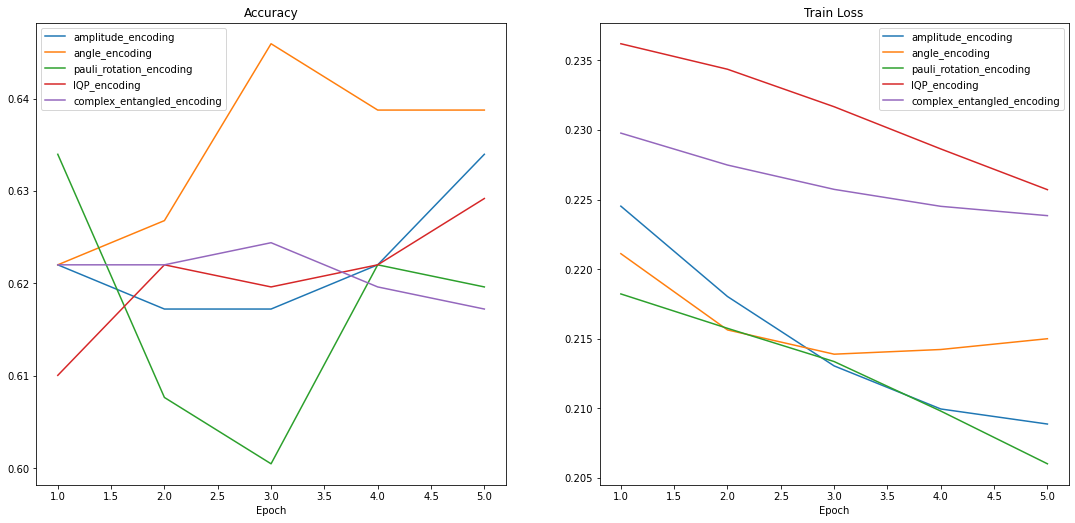

In [26]:
#plot results
x=[i for i in range(1,epoch+1)]
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18.5, 8.5)
for i in range(len(encoding_list)):
    ax1.plot(x,acc_list[i])
    ax1.set_title("Accuracy")
    ax1.legend(encoding_list)
    ax1.set_xlabel('Epoch')
    
    ax2.plot(x,trainloss_list[i])
    ax2.set_title("Train Loss")
    ax2.legend(encoding_list)
    ax2.set_xlabel('Epoch')

plt.legend(encoding_list)
plt.show()

Do another test with depth = 1

In [22]:
dimension = train_x.shape[1]
import math
num_qubit = int(math.log2(train_x.shape[1]))+1 
depth = 1
epoch = 5
lr = 0.01
batch_size = 32


acc_list = []
trainloss_list = []
for i in range(len(encoding_list)):
    encoding = encoding_list[i]
    time_start = time.time()
    print("Encoding method:", encoding)
    #Encoding
    quantum_train_x= SimpleDataset(dimension).encode(train_x, encoding, num_qubit)
    quantum_test_x= SimpleDataset(dimension).encode(test_x, encoding, num_qubit)
    quantum_train_x = paddle.to_tensor(quantum_train_x)
    quantum_test_x = paddle.to_tensor(quantum_test_x)
    
    
    acc,train_ls = train(
            quantum_train_x, 
            train_y,         
            quantum_test_x,  
            test_y,          
            N = num_qubit,   
            DEPTH = depth,      
            EPOCH = epoch,       
            LR = lr,        
            BATCH = batch_size,      
          )
    time_span = time.time() - time_start
    print(encoding,'time spend for training is :',time_span, 's')
    print()
    acc_list.append(acc)
    trainloss_list.append(train_ls)

Encoding method: amplitude_encoding
epoch: 1 loss: 0.21 train acc: 0.67 test acc: 0.58
epoch: 2 loss: 0.21 train acc: 0.67 test acc: 0.59
epoch: 3 loss: 0.20 train acc: 0.78 test acc: 0.60
epoch: 4 loss: 0.20 train acc: 0.78 test acc: 0.60
epoch: 5 loss: 0.20 train acc: 0.78 test acc: 0.59
--Rz(2.461)----Ry(5.928)----Rz(3.860)----*---------x----Ry(3.795)--
                                         |         |               
--Rz(4.105)----Ry(3.380)----Rz(0.596)----x----*----|----Ry(3.052)--
                                              |    |               
--Rz(2.953)----Ry(5.384)----Rz(2.167)---------x----*----Ry(1.139)--
                                                                   
amplitude_encoding time spend for training is : 3.295236825942993 s

Encoding method: angle_encoding
epoch: 1 loss: 0.28 train acc: 0.63 test acc: 0.61
epoch: 2 loss: 0.27 train acc: 0.63 test acc: 0.62
epoch: 3 loss: 0.25 train acc: 0.63 test acc: 0.62
epoch: 4 loss: 0.25 train acc: 0.63 test acc: 0

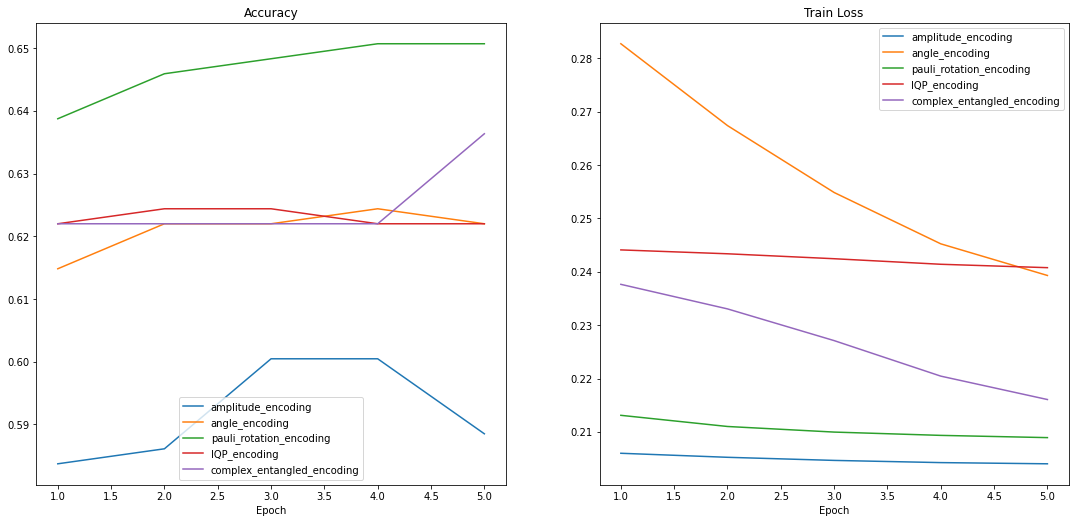

In [23]:
#plot results
x=[i for i in range(1,epoch+1)]
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18.5, 8.5)
for i in range(len(encoding_list)):
    ax1.plot(x,acc_list[i])
    ax1.set_title("Accuracy")
    ax1.legend(encoding_list)
    ax1.set_xlabel('Epoch')
    
    ax2.plot(x,trainloss_list[i])
    ax2.set_title("Train Loss")
    ax2.legend(encoding_list)
    ax2.set_xlabel('Epoch')

plt.legend(encoding_list)
plt.show()